# CLOSED LOOP SYSTEMS

This notebook is a companion to the slides for understanding closed loop systems.

# Preliminaries

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

# Antimony Model

$\$S_1 \xrightarrow{k_1 S_1} S_2$,
$S_2 \xrightarrow{k_2 S_3} S_3$,
$S_3 \xrightarrow{k_3 S_3} S_2$,
$S_2 \xrightarrow{k_2 S_3} \emptyset$,

In [3]:
# Constants
CONSTANT_DCT = {"k1": 1, "k2": 2, "k3": 3, "k4": 4}
s = sympy.Symbol("s")
REF = 10

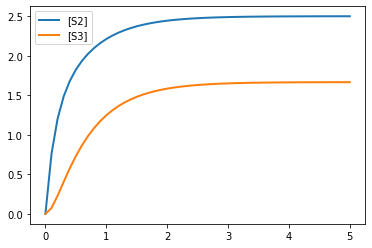

In [36]:
MODEL = """
$S1 -> S2; k1*$S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 0
k2 = 0
k3 = 0
k4 = 0
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
RR = te.loada(MODEL)
for k in CONSTANT_DCT.keys():
    RR[k] = CONSTANT_DCT[k]
RR.simulate()
RR.plot()

We are going to control ``S3`` by changing ``S2``.

In [37]:
ctlsb = ctl.ControlSBML(RR,  input_names=["S2"], output_names=["S3"])

In [38]:
numerator = CONSTANT_DCT["k2"]
denominator = [1, CONSTANT_DCT["k3"]]
tf = control.TransferFunction(numerator, denominator)
tf

TransferFunction(array([2]), array([1, 3]))

In [39]:
sys = ctlsb.makeNonlinearIOSystem("sys")

In [40]:
def controller_outfcn(_, __, u, param_dct):
    k = param_dct.get("k", 2)
    ref = param_dct.get("ref", REF)
    return k*([REF] - u[0])
#
controller = control.NonlinearIOSystem(
    None, controller_outfcn, inputs=['in'], outputs=['out'],
    name="controller")

In [41]:
# Create the closed loop system
closed_loop = control.interconnect(
  [sys, controller],       # systems
  connections=[
    ['sys.S2', 'controller.out'],
    ['controller.in',  'sys.S3'],
  ],
  inplist=["controller.in"],
  outlist=["sys.S2", "sys.S3"],
)

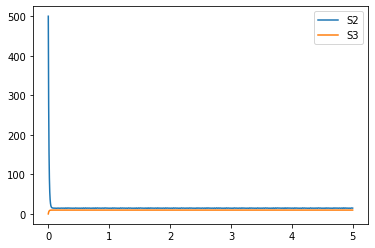

In [50]:
param_dct = {"k": 5, "ref": REF}
result = control.input_output_response(closed_loop, T=TIMES, params=param_dct)
plt.plot(TIMES, result.outputs[0], TIMES, result.outputs[1])
plt.legend(["S2", "S3"])

In [51]:
result.outputs[1][-2:]

array([9.70686073, 9.70714998])

In [52]:
G = 2/(s + 3)
G

2/(s + 3)

In [53]:
C = sympy.symbols("k")

In [54]:
H = C*G/(1 + C*G)
H.simplify()

2*k/(2*k + s + 3)

In [55]:
# Find the DC Gain
dct = dict(param_dct)
dct[s] = 0
sympy.N(param_dct["ref"]*H.subs(dct).simplify())

9.70873786407767

The DC Gain depends on ``k``. Need a large ``k`` to get a DC gain of 1.